In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import tensorflow as tf

## Chuẩn bị dữ liệu

In [2]:
import tensorflow as tf
import io
import numpy as np
import re

BOS = '<start>'
EOS = '<end>'
UTF_8 = 'UTF-8'

def preprocess_sentence(w, max_length):
    w = w.lower().strip()
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()

    # Truncate Length up to ideal_length
    w = " ".join(w.split()[:max_length+1])
    
    # Add start and end token 
    w = '{} {} {}'.format(BOS, w, EOS)
    # w = '{} {}'.format(w, EOS)
    return w

num_examples = 100000

inp_lines = io.open('data/train/train.vi', encoding=UTF_8).read().strip().split('\n')[:num_examples]
targ_lines = io.open('data/train/train.en', encoding=UTF_8).read().strip().split('\n')[:num_examples]

print(inp_lines[3])
print(targ_lines[3])
max_length = 100

inp_lines = [preprocess_sentence(inp, max_length) for inp in inp_lines]
targ_lines = [preprocess_sentence(targ, max_length) for targ in targ_lines]
    
print(inp_lines[3])
print(targ_lines[3])

# Tạo một đối tượng Tokenizer
inp_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' !"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
targ_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' !"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

# Xây dựng từ điển từ bộ dữ liệu
inp_tokenizer.fit_on_texts(inp_lines)
targ_tokenizer.fit_on_texts(targ_lines)

# Lấy từ điển từ và gán chỉ số từ
inp_to_index = inp_tokenizer.word_index
targ_to_index = targ_tokenizer.word_index

print(inp_to_index)


inp_tensor = inp_tokenizer.texts_to_sequences(inp_lines)
targ_tensor = targ_tokenizer.texts_to_sequences(targ_lines)

print(inp_tensor[3])
print(targ_tensor[3])


inp_tensor = tf.keras.preprocessing.sequence.pad_sequences(inp_tensor, padding='post', maxlen=max_length)
targ_tensor = tf.keras.preprocessing.sequence.pad_sequences(targ_tensor, padding='post', maxlen=max_length)

inp_tensor = tf.convert_to_tensor(inp_tensor, dtype=tf.int64)
targ_tensor = tf.convert_to_tensor(targ_tensor, dtype=tf.int64)


Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi . <end>
<start> headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog . <end>
{'<start>': 1, '<end>': 2, 'và': 3, 'tôi': 4, 'là': 5, 'một': 6, 'có': 7, 'chúng': 8, 'những': 9, 'của': 10, 'không': 11, 'bạn': 12, 'ta': 13, 'đó': 14, 'người': 15, 'trong': 16, 'các': 17, 'thể': 18, 'đã': 19, 'này': 20, 'được': 21, 'nó': 22, 'với': 23, 'sự': 24, 'cho': 25, 'quot': 26, 'ra': 27, 'làm': 28, 'ở': 29, 'mà': 30, 'điều': 31, 'để': 32, 'như': 33, 'về': 34, 'sẽ': 35, 'thế': 36, 'họ': 37, 'khi': 38, '

In [3]:
def texts_to_sequences(tokenizer, sentences):
    tar = []
    for word in sentences.split():
        if tokenizer.word_index.get(word) != None :
            tar.append(tokenizer.word_index.get(word))
    return tar

In [4]:
inp = texts_to_sequences(inp_tokenizer, inp_lines[3])
inp = tf.convert_to_tensor(inp, dtype=tf.int64)
inp

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([   1,    7,    9,  781,  532,   33,   36,   20,   38,  533,   34,
        299,  142,  380,  687,    3,   33,   36,   20,   38,   39,   34,
        259,  193,   11,  380,  103, 1737, 1655,    2], dtype=int64)>

In [5]:
# Định nghĩa hyperparameters
batch_size = 24
buffer_size = 8

# Tạo dataset từ inp_tensor và targ_tensor
dataset = tf.data.Dataset.from_tensor_slices((inp_tensor, targ_tensor))

# Pha trộn và phân lô dữ liệu
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

# Đặt kiểu dữ liệu của batch
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.int64), tf.cast(y, tf.int64)))

# Đặt prefetch để tải dữ liệu mẫu tiếp theo trong quá trình huấn luyện
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [6]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(24, 100), dtype=tf.int64, name=None), TensorSpec(shape=(24, 100), dtype=tf.int64, name=None))>

## Position Encoding

In [7]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [8]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # Sinusoid
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Sinusoid
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


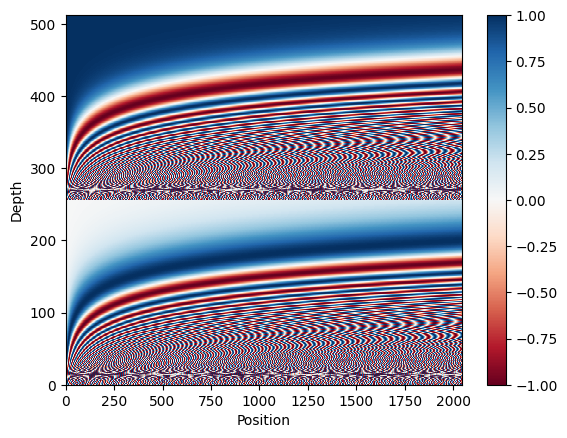

In [9]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Padding

In [10]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [11]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Multi-Head Attention

In [12]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

# FFN

In [14]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder Layer

In [15]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

# Decoder Layer

In [16]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

# Encoder

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

# Decoder

In [18]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer

In [19]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [20]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# Optimizer

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

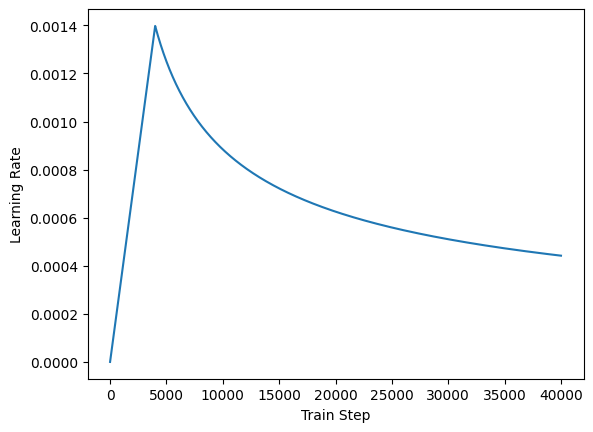

In [23]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [25]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Model

In [27]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(inp_tokenizer.word_counts) + 1,
    target_vocab_size=len(targ_tokenizer.word_counts) + 1,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

## CheckPoint

In [28]:
checkpoint_path = "./checkpoints_vi_en_old/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Train

In [32]:
EPOCHS = 500

In [33]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [45]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) >= 1:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 4.5706 Accuracy 0.3624
Epoch 1 Batch 50 Loss 4.3885 Accuracy 0.3593
Epoch 1 Batch 100 Loss 4.4131 Accuracy 0.3494
Epoch 1 Batch 150 Loss 4.3665 Accuracy 0.3518
Epoch 1 Batch 200 Loss 4.4197 Accuracy 0.3508
Epoch 1 Batch 250 Loss 4.4389 Accuracy 0.3506
Epoch 1 Batch 300 Loss 4.4444 Accuracy 0.3503
Epoch 1 Batch 350 Loss 4.4545 Accuracy 0.3494
Epoch 1 Batch 400 Loss 4.4753 Accuracy 0.3484
Epoch 1 Batch 450 Loss 4.4875 Accuracy 0.3483
Epoch 1 Batch 500 Loss 4.4918 Accuracy 0.3475
Epoch 1 Batch 550 Loss 4.4821 Accuracy 0.3484
Epoch 1 Batch 600 Loss 4.4845 Accuracy 0.3490
Epoch 1 Batch 650 Loss 4.4819 Accuracy 0.3497
Epoch 1 Batch 700 Loss 4.4712 Accuracy 0.3498
Epoch 1 Batch 750 Loss 4.4693 Accuracy 0.3504
Epoch 1 Batch 800 Loss 4.4666 Accuracy 0.3503
Epoch 1 Batch 850 Loss 4.4628 Accuracy 0.3502
Epoch 1 Batch 900 Loss 4.4534 Accuracy 0.3504
Epoch 1 Batch 950 Loss 4.4568 Accuracy 0.3503
Epoch 1 Batch 1000 Loss 4.4542 Accuracy 0.3501
Epoch 1 Batch 1050 Loss 4.4517 Accur

KeyboardInterrupt: 

In [35]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2939136   
                                                                 
 decoder (Decoder)           multiple                  5782272   
                                                                 
 dense_64 (Dense)            multiple                  4760874   
                                                                 
Total params: 13,482,282
Trainable params: 13,482,282
Non-trainable params: 0
_________________________________________________________________


In [36]:
class Translator(tf.Module):
  def __init__(self, inp_tokenizer, targ_tokenizer, transformer):
    self.inp_tokenizer = inp_tokenizer
    self.targ_tokenizer = targ_tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=30):
   
    # assert isinstance(sentence, tf.Tensor)
    # if len(sentence.shape) == 0:
    #  sentence = sentence[tf.newaxis]
      
    # sentence = sentence.numpy().tolist()
    # sentence = ' '.join(sentence)
    sentence = texts_to_sequences(self.inp_tokenizer, sentence)
    # print(sentence)
    sentence = tf.convert_to_tensor(sentence, dtype=tf.int64)
    print(sentence)
    encoder_input = sentence
    # print(encoder_input)
    # if len(sentence.shape) == 0:
    #  sentence = sentence[tf.newaxis]
    encoder_input = tf.expand_dims(encoder_input, 0)

    
    start = targ_tokenizer.word_index.get(BOS)
    start = tf.cast(tf.expand_dims(start, 0), tf.int64)
    end = targ_tokenizer.word_index.get(EOS)
    # print(start)
    
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    print(output)
    # output.shape (1, tokens)
    # text = tokenizers.en.detokenize(output)[0]  # shape: ()

    # tokens = tokenizers.en.lookup(output)[0]

    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    output = tf.squeeze(output)
    output = output.numpy().tolist()
    
    text = ""
    for index in output:
      text += targ_tokenizer.index_word.get(int(index)) + " "
      
    return text, attention_weights

In [37]:
translator = Translator(inp_tokenizer, targ_tokenizer, transformer)

In [38]:
def print_translation(sentence, text, truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {text}')
  print(f'{"Truth":15s}: {truth}')

In [39]:
sentence = "Và tất cả các trang đều được xem xét bởi 400 khoa học gia và nhà phê bình khác từ 113 quốc gia ."
ground_truth = "And all of those pages were reviewed by another 400-plus scientists and reviewers , from 113 countries ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20))
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1    3   96   59   17  444  203   21  187  621   92 1601  323   64
  146    3   77 1111  266   67   49 7519    2], shape=(23,), dtype=int64)
tf.Tensor(
[[  1   4   3 253 113  15   9   3 656 237  15 192   5  37  12  11   3 422
  366   4   3 354  16   2]], shape=(1, 24), dtype=int64)
Input:         : Và tất cả các trang đều được xem xét bởi 400 khoa học gia và nhà phê bình khác từ 113 quốc gia .
Prediction     : <start> and the second thing is that the average person is able to do it in the united states and the u s <end> 
Truth          : And all of those pages were reviewed by another 400-plus scientists and reviewers , from 113 countries .


In [40]:
sentence = "Mô hình của chúng tôi gồm hàng trăm ngàn thùng xếp chồng tính toán với hàng trăm biến số trong thời gian cực ngắn"
ground_truth = "Our models have hundreds of thousands of grid boxes calculating hundreds of variables each , on minute timescales ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1  363   98   10    8    4  761  167  490  843 1562  839 1085  159
  472   23  167  490  299   78   16  124    2], shape=(23,), dtype=int64)
tf.Tensor(
[[  1  14   6  41  62   5 127   8 112  36   3 354  16   4  69   3 354  16
   11   3 422 366  11   3 422 366   2]], shape=(1, 27), dtype=int64)
Input:         : Mô hình của chúng tôi gồm hàng trăm ngàn thùng xếp chồng tính toán với hàng trăm biến số trong thời gian cực ngắn
Prediction     : <start> we apos re going to take a look at the u s and see the u s in the united states in the united states <end> 
Truth          : Our models have hundreds of thousands of grid boxes calculating hundreds of variables each , on minute timescales .


In [41]:
sentence = "Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển ."
ground_truth = "They are both two branches of the same field of atmospheric science ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[   1   59  185  203    5    6 2153   10  120    6  786  433   16  617
  323   64  380  941    2], shape=(19,), dtype=int64)
tf.Tensor(
[[  1   3 253 113  15   3 263   7  42  66  24   8 133   7 259  11   3 243
   66  24   8 133   7 259   2]], shape=(1, 25), dtype=int64)
Input:         : Cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển .
Prediction     : <start> the second thing is the number of people who have a lot of money in the country who have a lot of money <end> 
Truth          : They are both two branches of the same field of atmospheric science .


In [42]:
sentence = "Chính vì lượng khí thải rất lớn , nó có ý nghĩa quan trọng với hệ thống khí quyển ."
ground_truth = "And because it &apos;s so much stuff , it &apos;s really important for the atmospheric system ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor(
[  1  85  45 193 380 923  51 119  22   7 102 211  80 186  23 156 209 380
 941   2], shape=(20,), dtype=int64)
tf.Tensor(
[[   1   54    3   77   15    3  142   34    3   77    6   16  118 1076
     2]], shape=(1, 15), dtype=int64)
Input:         : Chính vì lượng khí thải rất lớn , nó có ý nghĩa quan trọng với hệ thống khí quyển .
Prediction     : <start> because the world is the same as the world apos s most expensive <end> 
Truth          : And because it &apos;s so much stuff , it &apos;s really important for the atmospheric system .


In [43]:
sentence = "Hôm nay tôi đi học"
ground_truth = "Today, I go to school"

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor([  1 428 214   4  75  64   2], shape=(7,), dtype=int64)
tf.Tensor([[  1  18  10   6  79  62   5 193  28  17   2]], shape=(1, 11), dtype=int64)
Input:         : Hôm nay tôi đi học
Prediction     : <start> so i apos m going to start with this <end> 
Truth          : Today, I go to school


In [44]:
sentence = "Bắt chước những gì bạn nhìn thấy ."
ground_truth = "You can mimic what you can see ."

translated_text, attention_weights = translator(
    preprocess_sentence(sentence, max_length=20), max_length=200)
print_translation(sentence, translated_text, ground_truth)

tf.Tensor([   1  115 1582    9   50   12  113   54    2], shape=(9,), dtype=int64)
tf.Tensor([[ 1 25 37 13 37 28  9  2]], shape=(1, 8), dtype=int64)
Input:         : Bắt chước những gì bạn nhìn thấy .
Prediction     : <start> what do you do with that <end> 
Truth          : You can mimic what you can see .
